In [2]:
using RCall

In [ ]:
P = Array{Float64}(100, 100)

In [37]:
A = readcsv("E:/Classes/BiostatisticsM280/Submissions/biostat-m280-JohnShamshoian/HW3/A.txt");
# A 500 x 500 connectivity matrix

In [34]:
A = [1 1; 1 0; 1 -1]
b = [1; 0; 0]
alu = lufact(A, Val{true})
A * (alu[:U] \ (alu[:L] \ b))
A * [0.366025; 0.767327]

3-element Array{Float64,1}:
  1.13335 
  0.366025
 -0.401302

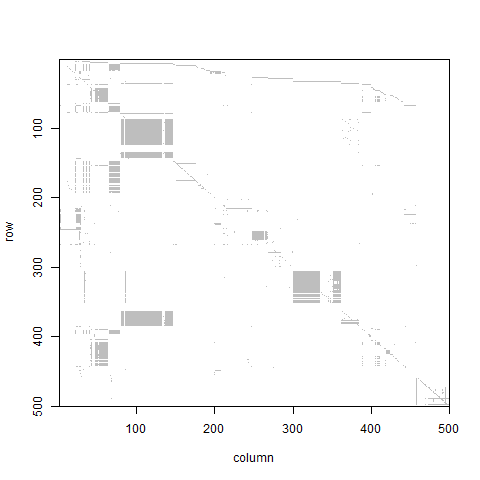

RCall.RObject{RCall.NilSxp}
NULL


In [8]:
@rput A

R"""
library(SparseM)
image(as.matrix.csr(A))
"""

In [ ]:
# Number of edges
sum(A)

In [ ]:
# Number of dangling nodes
500 * 500 - sum(A)

In [ ]:
# page with max in-degree
indmax(sum(A, 1))

In [ ]:
# page with max out-degree
indmax(sum(A, 2))

In [ ]:
imagesc(A .< 0.5)

In [ ]:
using PyPlot

In [ ]:
using Gadfly

In [ ]:
size(A)

In [134]:
function transition(A, p)
    n = size(A, 1)
    P = Matrix{Float64}(size(A))
    r = sum(A, 2)
    
    for j = 1:n
        for i = 1:n
            P[i, j] = (p * A[i, j]) *(r[i] > 0) #+ (1.0 - p) / n) * (r[i] > 0) + 1.0 / n * (r[i] == 0)
        end
    end
    P
end

transition (generic function with 1 method)

 overwritten at In[134]:2.


In [38]:
myP = transition(A, .85)

500×500 Array{Float64,2}:
 0.0003     0.0306571  0.0306571  …  0.0003     0.0003     0.0003   
 0.0003     0.0003     0.0003        0.0003     0.0003     0.0003   
 0.002      0.002      0.002         0.002      0.002      0.002    
 0.002      0.002      0.002         0.002      0.002      0.002    
 0.0003     0.0003     0.0003        0.0003     0.0003     0.0003   
 0.0003     0.0003     0.0003     …  0.0003     0.0003     0.0003   
 0.0389364  0.0003     0.0003        0.0003     0.0003     0.0003   
 0.0124429  0.0003     0.0003        0.0003     0.0003     0.0003   
 0.0389364  0.0003     0.0003        0.0003     0.0003     0.0003   
 0.0389364  0.0003     0.0003        0.0003     0.0003     0.0003   
 0.0191889  0.0003     0.0003     …  0.0003     0.0003     0.0003   
 0.0389364  0.0003     0.0003        0.0003     0.0003     0.0003   
 0.0372565  0.0003     0.0003        0.0003     0.0003     0.0003   
 ⋮                                ⋱                                 
 0.0003 

In [228]:
function transition2(A, p)
    n, m = size(A)
    u, v, w = Array(Float64, 500, Array(Float64, 500), Array(Float64, 500)

    for i = 1:500
        if sum(A, 2)[i] == 0.0
            u[i] = 0.0
            v[i] = 0.0
            w[i] = 1.0
        else
            u[i] = 1.0 / sum(A, 2)[i]
            v[i] = 1.0
            w[i] = 0.0
        end
    end
    return p * Diagonal(u) * A  + Diagonal(v) * ones(n) * ones(n)' * (1 - p) / n + Diagonal(w) * ones(n) * ones(n)' / n
end

transition2 (generic function with 1 method)

 at In[220]:2 overwritten at In[228]:2.


In [243]:
function transition(A, p)
    n = size(A, 1)
    P = Matrix{Float64}(n, n)
    r = sum(A, 2)
    
    for j = 1:n
        for i = 1:n
            P[i, j] = (p * A[i, j] / r[i] + (1.0 - p) / n) * (r[i] > 0) + 1.0 / n * (r[i] == 0)
        end
    end
    P
end

transition (generic function with 1 method)

 overwritten at In[243]:2.


In [267]:
transition2(A, p)' - I

500×500 Array{Float64,2}:
 -0.9992      0.0008   0.002   0.002  …   0.0008   0.0008   0.0008   0.002
  0.0222286  -0.9992   0.002   0.002      0.0008   0.0008   0.0008   0.002
  0.0222286   0.0008  -0.998   0.002      0.0008   0.0008   0.0008   0.002
  0.0222286   0.0008   0.002  -0.998      0.0008   0.0008   0.0008   0.002
  0.0222286   0.0008   0.002   0.002      0.0008   0.0008   0.0008   0.002
  0.0222286   0.0008   0.002   0.002  …   0.0008   0.0008   0.0008   0.002
  0.0222286   0.0008   0.002   0.002      0.0008   0.0008   0.0008   0.002
  0.0222286   0.0008   0.002   0.002      0.0008   0.0008   0.0008   0.002
  0.0222286   0.0008   0.002   0.002      0.0008   0.0008   0.0008   0.002
  0.0222286   0.0008   0.002   0.002      0.0008   0.0008   0.0008   0.002
  0.0222286   0.0008   0.002   0.002  …   0.0008   0.0008   0.0008   0.002
  0.0222286   0.0008   0.002   0.002      0.0008   0.0008   0.0008   0.002
  0.0222286   0.0008   0.002   0.002      0.0008   0.0008   0.0008   0.002

In [245]:
.6/28 + .4/500

0.022228571428571427

In [271]:
A = [1 1; 0 0; 1 -2]
b = [1; 0; 0]
qrfact(A,Val{true}) \ b

2-element Array{Float64,1}:
 0.666667
 0.333333

In [12]:
A

500×500 Array{Float64,2}:
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.